[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/soloyant/deltax_workshop_2024/blob/main/tutorials/1_HydrodynamicModeling_ANUGA/[3]ANUGA_model_run.ipynb)

<div style="text-align: center;">
    <img src="notebook_illustrations/deltax_2020.png" alt="Delta-X Logo" style="height: 100px; width: auto; display: inline;">
    <img src="notebook_illustrations/Tribrand_ColorBlack_rgb_16x3_160601.png" alt="JPL Logo" style="height: 100px; width: auto; display: inline;">
</div>
<h1 style="text-align: center;">Delta-X 2024 Application Workshop - May 8, 2024</h1>
<h2 style="text-align: center;">Anuga Hydrodynamic Modeling: Hands On Exercises</h2>
<h2 style="text-align: center;">Part 3/5: Model Run</h2>

<h3>Author information:</h3>

Antoine Soloy, Ph.D.  
Division 334F, Caltech - Jet Propulsion Laboratory  
4800 Oak Grove Drive, Pasadena, CA, USA  91109-8099  
Contact: antoine.soloy@jpl.nasa.gov

# I - Import packages and define the working directories

In [1]:
import sys

if 'google.colab' in sys.modules:
  # In case the notebook is opened in google collab, here we download/install all the files we need behind the scenes
  try:
      import os
      os.chdir('/content')
      # Grab workbook files into colab directory
      !git clone https://github.com/soloyant/deltax_workshop_2024.git
      # Install everything using some bash scripts
      !/bin/bash /content/deltax_workshop_2024/tutorials/1_HydrodynamicModeling_ANUGA/utils/anuga_tools/install_anuga_colab.sh
      os.chdir('/content/deltax_workshop_2024/tutorials/1_HydrodynamicModeling_ANUGA/')
  except:
      pass

In [2]:
import os
from pathlib import Path
import rasterio as rio
import numpy as np
import pandas as pd
import geopandas as gpd
import cmocean
from dataretrieval import nwis
import noaa_coops as noaa
from tqdm import notebook 
import matplotlib
import matplotlib.pyplot as plt
import anuga
from anuga import Set_stage, Reflective_boundary
from anuga.structures.inlet_operator import Inlet_operator

from utils.anuga_tools.baptist_operator import Baptist_operator
from utils.anuga_tools import anuga_tools as at
from utils import data_processing_tools as dpt

# Define the path to scripts and data
workshop_dir = os.getcwd()
# # Alternatively:
# workshop_dir = '/path/to/1_HydrodynamicModeling_ANUGA'
data_dir = os.path.join(workshop_dir, 'data')
model_inputs_dir = os.path.join(workshop_dir, 'model_inputs')
model_outputs_dir = os.path.join(workshop_dir, 'model_outputs')
if 'google.colab' in sys.modules:
    data_dir = os.path.join(data_dir, 'collab')
    model_inputs_dir = os.path.join(model_inputs_dir, 'collab')
    model_outputs_dir = os.path.join(model_outputs_dir, 'collab')
model_visuals_dir = os.path.join(workshop_dir, 'visuals')
model_validation_dir = os.path.join(workshop_dir, 'validation')

for d in [model_inputs_dir, model_outputs_dir, model_visuals_dir, model_validation_dir]:
    Path(d).mkdir(parents=True, exist_ok=True)
        
# Install custom anuga modules
f_py_install = os.path.join(workshop_dir, 'utilities/anuga_tools/install.py')
!python $f_py_install

# Check if the user operating system is windows (useful )
is_windows = sys.platform.startswith('win')

python: can't open file '/Users/soloy/Documents/GitHub/deltax_workshop_2024/tutorials/1_HydrodynamicModeling_ANUGA/utilities/anuga_tools/install.py': [Errno 2] No such file or directory


# II - Boundary classification

This first step is necessary to let the model know where to apply different conditions (tide, walls, transmissive...) at the model boundary. After loading the model domain polygon, select the "Draw a Polygon" tool and circle around the offshore boundary of your domain, while making sure to select at least 2 consecutive corners of the domain polygon.

In [3]:
# First import the domain generated during the DEM processing step
f_domain = os.path.join(data_dir, 'dxws_domain.shp')
domain_gdf = gpd.read_file(f_domain)
domain_polygon = np.asarray(domain_gdf.geometry[0].boundary.xy).T

# Convert it to WGS84 to be able to display it on the next map
domain_gdf_4326 = domain_gdf.to_crs(epsg=4326)
domain_polygon_4326 = np.asarray(domain_gdf_4326.geometry[0].boundary.xy).T

In [4]:
# Identify the tide boundary 
f_bay_ROI = os.path.join(data_dir, 'bay_ROI.shp')
if 'google.colab' not in sys.modules:
    dpt.draw_polygon(filename=f_bay_ROI, epsg=32615, domain_polygon=domain_polygon_4326)

Map(center=[29.5, -91.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Button(description='Save to Shapefile', style=ButtonStyle())

Output()

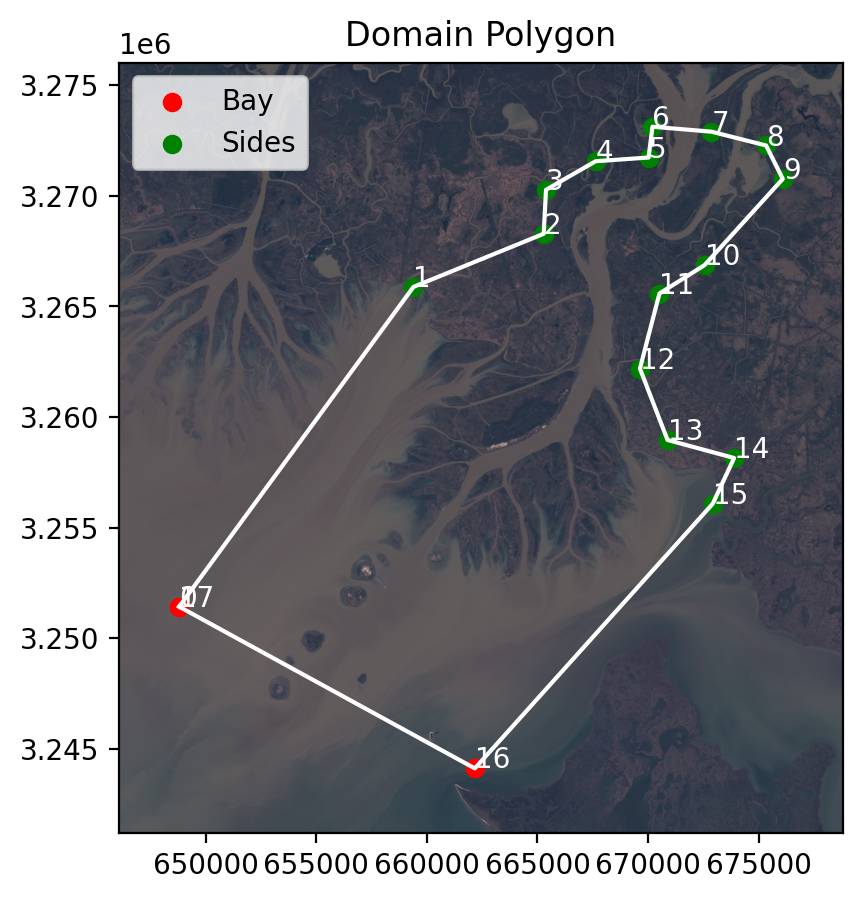

In [5]:
%matplotlib inline

# Import boundary classification
bay_ROI_gdf = gpd.read_file(f_bay_ROI)
bay_ROI_polygon = np.asarray(bay_ROI_gdf.geometry[0].boundary.xy).T
bay_ind, sides_ind = dpt.classify_points(domain_polygon, bay_ROI_polygon)

xmin = np.nanmin(domain_polygon[:,0])
xmax = np.nanmax(domain_polygon[:,0])
ymin = np.nanmin(domain_polygon[:,1])
ymax = np.nanmax(domain_polygon[:,1])

# Background imagery
f_bg_img_tif = os.path.join(data_dir, 'misissippi_S2_background_image.tif')
bg_img_src = rio.open(f_bg_img_tif)
bg_img = np.stack([bg_img_src.read(i) for i in range(1, bg_img_src.count+1)], axis=2)
bg_img_extent = [bg_img_src.bounds.left, bg_img_src.bounds.right,
                 bg_img_src.bounds.bottom, bg_img_src.bounds.top]

# Data visualization
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
ax.imshow(bg_img, extent=bg_img_extent)
ax.plot(domain_polygon[:,0], domain_polygon[:,1], color='white')
ax.scatter(domain_polygon[bay_ind, 0], domain_polygon[bay_ind, 1], color='red', label='Bay')
ax.scatter(domain_polygon[sides_ind, 0], domain_polygon[sides_ind, 1], color='green', label='Sides')
for ii in bay_ind:
    ax.text(domain_polygon[ii][0], domain_polygon[ii][1], str(ii), color='white')
for ii in sides_ind:
    ax.text(domain_polygon[ii][0], domain_polygon[ii][1], str(ii), color='white')
ax.legend()
ax.set_title('Domain Polygon')
ax.set_xlim([xmin-.1*(xmax-xmin), xmax+.1*(xmax-xmin)])
ax.set_ylim([ymin-.1*(ymax-ymin), ymax+.1*(ymax-ymin)])

plt.savefig(os.path.join(model_visuals_dir, 'domain_boundary_classification.png'))
plt.show()

Now, let us identify the segment along which discharge will be forced into the model. To do this, select the "Draw a Polyline" button and select the extremities of the transect where the discharge boundary needs to be applied. Clic a second time on the last point to end the drawing, and hit "Save".

In [6]:
# Define the discharge transect
f_discharge_transect = os.path.join(data_dir, 'discharge_transect.shp')
if 'google.colab' not in sys.modules:
    dpt.draw_line_and_polygon_interaction(filename=f_discharge_transect, epsg=32615, domain_polygon=domain_polygon_4326)


Map(center=[29.5, -91.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Button(description='Save Line Inside Polygon', style=ButtonStyle())

Output()

# III - Mesh generation

To estimate the approximate surface area to be used as an input to the mesher function, we can use the formula for the area of an equilateral triangle:  
$\text{Area} = \frac{\sqrt{3}}{4} \times a^2$  
Where a is the length of each side of the triangle.


Mesh contains 67742 nodes and 134469 triangles.


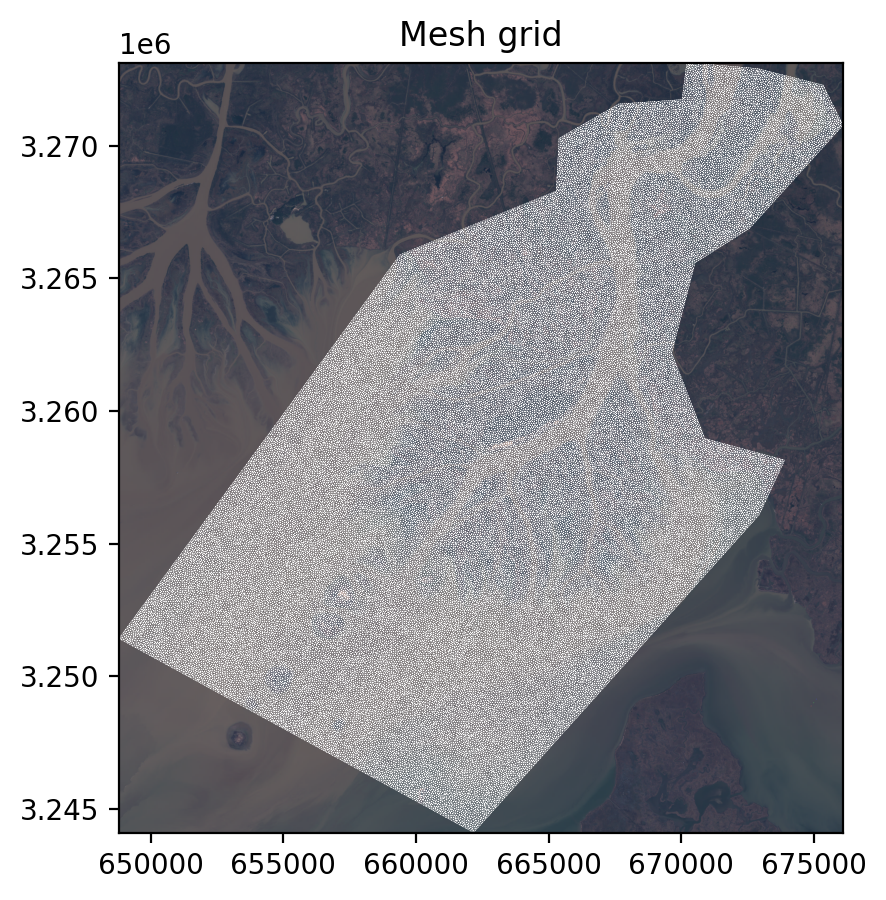

In [7]:
%matplotlib inline

# Generate the mesh grid
boundary_tags={'bay': bay_ind, 
               'sides': sides_ind}
triangle_edge_length = 200 #m

domain = anuga.create_domain_from_regions(domain_polygon, 
                                          boundary_tags, 
                                          maximum_triangle_area=dpt.calculate_area_of_equilateral_triangle(triangle_edge_length))

# Store mesh coordinates
points = domain.nodes
cells = domain.triangles

# Display mesh count
print(f'Mesh contains {np.shape(points)[0]} nodes and {np.shape(cells)[0]} triangles.')

# Data visualization
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
ax.imshow(bg_img, extent=bg_img_extent)
ax.triplot(points[:,0]+xmin, points[:,1]+ymin, cells, linewidth=0.1, color='white')
plt.title('Mesh grid')
plt.axis('scaled')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

plt.savefig(os.path.join(model_visuals_dir, 'model_mesh.png'))
plt.show()

Alternatively, one can use a different approach and take advantage of the triangular mesh's flexibility and refine/relax the grid where finer/coarser resolution should be used. 
Here are a few options:
- https://github.com/CHLNDDEV/OceanMesh2D
- https://github.com/passaH2O/meshrefinement
- https://nrc.canada.ca/en/research-development/products-services/software-applications/blue-kenuetm-software-tool-hydraulic-modellers

# V - Model Settings
The following notebook cell is automatically saved as a file named model_settings.py when activated. This file will store some useful information regarding the setting of the model (e.g. time, input gauges, output file paths) and will allow us to easily process the model output later on.

In [8]:
%%writefile model_settings.py
# ------------------------------------------------------------------------------
# Settings
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import os
import utm
import sys

# Define the path to scripts and data
workshop_dir = os.getcwd()
data_dir = os.path.join(workshop_dir, 'data')
model_inputs_dir = os.path.join(workshop_dir, 'model_inputs')
model_outputs_dir = os.path.join(workshop_dir, 'model_outputs')
if 'google.colab' in sys.modules:
    data_dir = os.path.join(data_dir, 'collab')
    model_inputs_dir = os.path.join(model_inputs_dir, 'collab')
    model_outputs_dir = os.path.join(model_outputs_dir, 'collab')
model_visuals_dir = os.path.join(workshop_dir, 'visuals')
model_validation_dir = os.path.join(workshop_dir, 'validation')

# Simulation time definition
sim_starttime = pd.to_datetime('2021-03-27 00:00:00', format="%Y-%m-%d %H:%M:%S", utc=True)
sim_endtime = pd.to_datetime('2021-03-28 00:00:00', format="%Y-%m-%d %H:%M:%S", utc=True)
sim_timestep = pd.to_timedelta(60, 'm')
sim_total_duration = (sim_endtime-sim_starttime)
data_download_dates = (str(sim_starttime-pd.to_timedelta(1, 'd'))[0:10].replace(' ', '').replace(':', ''),
                       str(sim_endtime+pd.to_timedelta(1, 'd'))[0:10].replace(' ', '').replace(':', ''))
sim_time = np.arange(sim_starttime, sim_endtime+sim_timestep, sim_timestep)

sim_starttime_str = str(sim_starttime)[0:19].replace('-', '').replace(' ', '').replace(':', '')

# Output file naming
domain_name = 'DX_Workshop'
model_name = f'{sim_starttime_str}_{domain_name}_{sim_total_duration.days}_days'

# Boundary Conditions
discharge_gauge_x, discharge_gauge_y = utm.from_latlon(29.692611, -91.211833)[0:2] # Morgan City
discharge_gauge_ID = ('07381600', 'Morgan City', discharge_gauge_x, discharge_gauge_y)

tide_gauge_x, tide_gauge_y = utm.from_latlon(29.373057, -91.383868)[0:2] # Eugene Island
tide_gauge_ID = ('8764314', 'Eugene Island', tide_gauge_x, tide_gauge_y)

# Gauges filepath
f_discharge =  os.path.join(model_inputs_dir, 'Discharge_at_%s_%s-%s.csv' % (
               discharge_gauge_ID[1],
               data_download_dates[0].replace('-', ''), 
               data_download_dates[1].replace('-', '')))

f_tides =  os.path.join(model_inputs_dir, 'Tides_at_%s_%s-%s.csv' % (
              tide_gauge_ID[1],
              data_download_dates[0].replace('-', ''), 
              data_download_dates[1].replace('-', '')))

Writing model_settings.py


In [9]:
# Save settings to input directory
f_model_settings_in = os.path.join(workshop_dir, 'model_settings.py')
f_model_settings_out = os.path.join(model_inputs_dir, 'model_settings.py')
if os.path.exists(f_model_settings_in):
    os.replace(f_model_settings_in, f_model_settings_out)

# Import all settings as global variables
if 'google.colab' not in sys.modules:
    from model_inputs.model_settings import *
else:
    from model_inputs.collab.model_settings import *

# VI - Boundary conditions

## DEM Interpolation

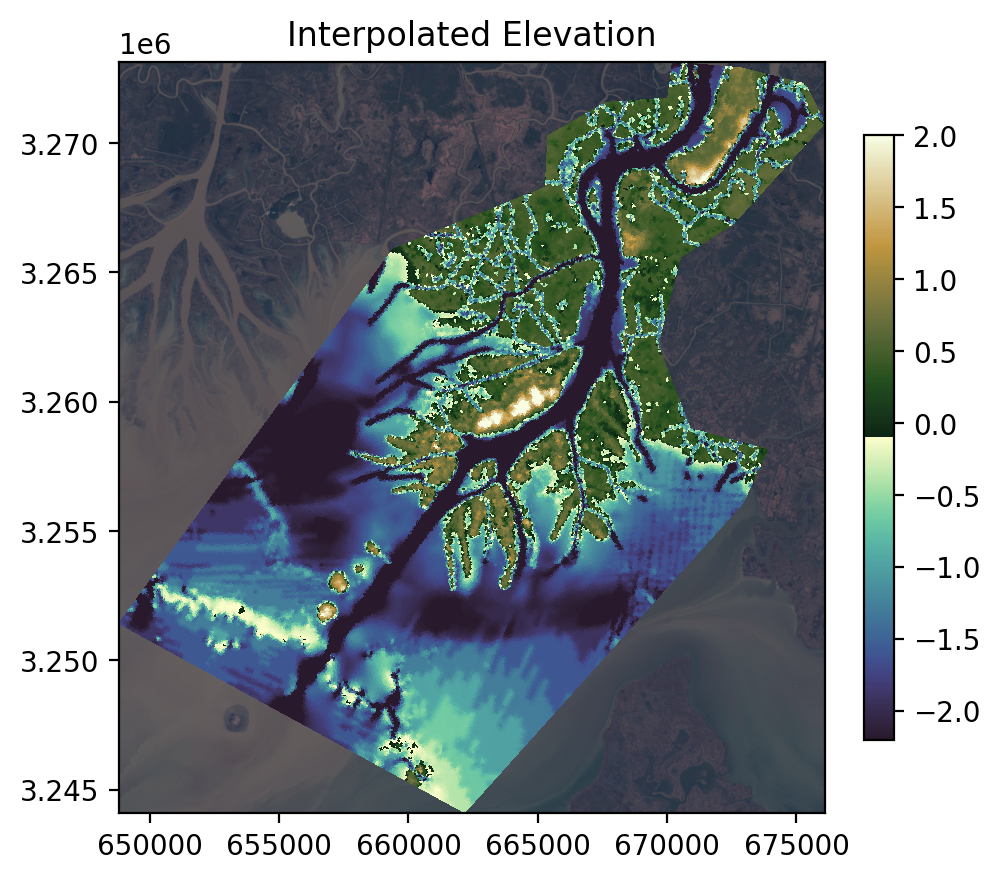

In [10]:
%matplotlib inline

# Interpolate DEM to the model mesh
f_edited_DEM_asc = os.path.join(model_inputs_dir, 'DeltaX_MultiSource_DEM_Atchafalaya-Terrebonne_Basin_2021_V1_edited.asc')
domain.set_quantity('elevation', filename=f_edited_DEM_asc)

# Data visualization
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
ax.imshow(bg_img, extent=bg_img_extent)
im = ax.tripcolor(points[:,0]+xmin, points[:,1]+ymin, cells, 
                  facecolors=domain.get_quantity('elevation').centroid_values,
                  vmax=-2, vmin=2, cmap='cmo.topo')
plt.colorbar(im, fraction=0.039)
ax.set_title("Interpolated Elevation")
ax.axis('scaled')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

plt.savefig(os.path.join(model_visuals_dir, 'DEM_meshed.png'))
plt.show()

## Tide and Discharge

### Datasets citations:
- NOAA (2023). Water levels at Eugene Island, North of, Atchafalaya Bay, LA - 8764314 [Data file], Retrieved from https://tidesandcurrents.noaa.gov/stationhome.html?id=8764314
- USGS (2023). Discharge of the Lower Atchafalaya River at Morgan City, LA - 07381600 [Data file], Retrieved from https://waterdata.usgs.gov/monitoring-location/07381600/


In [11]:
# Prepare boundary condition files for ANUGA simulation

# DISCHARGE
# Load discharge transect
discharge_transect_gdf = gpd.read_file(f_discharge_transect)
discharge_loc = np.asarray(discharge_transect_gdf.geometry[0].xy).T.tolist()

# Download discharge data
discharge_nwis = nwis.get_record(site=discharge_gauge_ID[0], start=data_download_dates[0], 
                      end=data_download_dates[1], service='iv', parameterCd = '00060')

# Convert to metric
discharge_nwis['Q'] = discharge_nwis['00060']*0.028316847 # CFS to m3/s

# # Filter time
discharge_nwis = discharge_nwis[discharge_nwis.index >= data_download_dates[0]][['Q']]

# Save to disk
discharge_nwis.to_csv(f_discharge, index_label='datetime')

# TIDES
# Download tide data
tides_noaa = noaa.Station(tide_gauge_ID[0]) 
tides_noaa = tides_noaa.get_data(begin_date=data_download_dates[0].replace('-',''),
                                 end_date=data_download_dates[1].replace('-',''),
                                 product="water_level", datum='MLLW', units="metric", 
                                 time_zone="gmt")

if 'google.colab' in sys.modules or is_windows:
    tides_noaa = tides_noaa[['water_level']]
else:
    tides_noaa = tides_noaa[['v']]
    tides_noaa.columns = ['water_level']

# Save to disk
tides_noaa.to_csv(f_tides, index_label='datetime') 


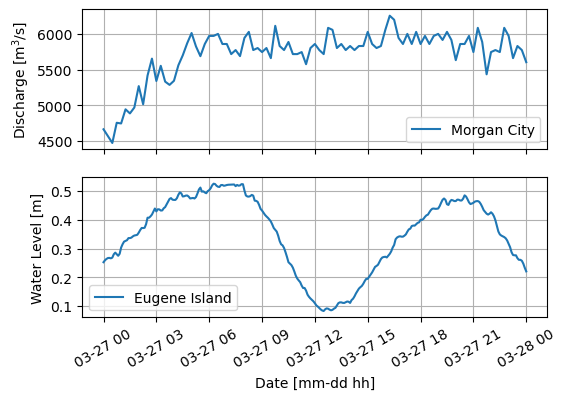

In [12]:
%matplotlib inline

# Prepare boundary condition functions for Anuga
discharge_function = at.GenerateHydrograph(filename = f_discharge,
                                            smoothing = False, 
                                            t_start=sim_starttime, 
                                            t_end=sim_endtime, 
                                            t_step=sim_timestep) 

tide_function = at.GenerateTideGauge(filename = f_tides,
                                      t_start = sim_starttime, 
                                      t_end = sim_endtime, 
                                      t_step = sim_timestep,
                                      offset = -.36,
                                      smoothing = False,
                                      smoothing_span = .1)

# Data visualization
t = (sim_time-sim_time[0]).astype('timedelta64[s]').astype(float)
discharge_ts = [discharge_function(i) for i in t]
tide_ts = [tide_function(i) for i in t]

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(6,4), dpi=100)
ax1.plot(sim_time, discharge_ts, label=discharge_gauge_ID[1])
ax1.legend()
ax1.grid('on')
ax1.set_ylabel('Discharge [m$^3$/s]')
ax1.set_xticklabels([])

ax2.plot(sim_time, tide_ts, label=tide_gauge_ID[1])
ax2.legend()
ax2.grid('on')
ax2.set_xlabel('Date [mm-dd hh]')
ax2.set_ylabel('Water Level [m]')
for tick in ax2.get_xticklabels():
    tick.set_rotation(30)

plt.savefig(os.path.join(model_visuals_dir, 'hydrodynamic_inputs.png'))
plt.show()

## Friction
The next step is to initialize friction over the entire surface of the domain. Different bed materials, geometries and types of land cover offer varying resistance to water flow, making it useful to classify each cell into groups that are likely to exhibit similar friction. This classification was completed in the previous notebook.  

The identified friction classes now need to be associated with specific friction values. A common approach is to first refer to published tables of values (e.g., https://doi.org/10.3133/wsp2339). Then, run the model and compare the results with observations to determine if the friction for a given class is either too high or too low. For example, if water flows too slowly in large channels, the friction intensity should be decreased before rerunning the model.  

This manual calibration process can be lengthy and complex due to the nonlinear interactions between water flows in different classes, requiring multiple model runs until results converge with in-situ observations. In the next notebook cell, we provide the values obtained after the calibration process performed for the ANUGA models developed as part of the Delta-X Mission.  

There are two main methods to define friction: using Manning or Chezy formulations. Both aim to describe the same phenomenon but from different philosophical approaches (see equations below). Hydrodynamic models usually require the user to choose one formulation over the other, and results can differ based on this choice. The ANUGA model natively considers only the Manning formulation, but it was later enhanced with an add-on to support Baptist-Chezy friction values [1], designed specifically to account for friction due to vegetation [2].

To account for the complexities of the Louisiana Coast, our model will use calibrated Manning $n$ values for the ocean and channels, and Baptist-Chezy $Cv$ values for forests, broadleaf herbaceous areas, freshwater grass, saltmarsh grass, and tall grass classes. Aquatic vegetation will be defined using Manning $n$ values due to a lack of in-situ measurements for this specific class. The Baptist equation [2] requires information on stem density, height, and diameters for each class, which was provided by the Delta-X Mission in a comprehensive dataset [3]. However, these values only offer a likely good starting estimate of friction and the need to calibrate the model remains, which is why we use a calibration scaler array.  

<table>
<tr>
    <td valign="top">

**Manning Equation**
$$
v = \frac{1}{n} R^{2/3} S^{1/2}
$$
Where:
- \( v \) = flow velocity
- \( n \) = Manning roughness coefficient
- \( R \) = hydraulic radius (area of the cross-section of flow divided by the wetted perimeter)
- \( S \) = slope of the energy grade line or hydraulic gradient

    </td>
    <td valign="top">

**Chezy Equation**
$$
v = C \sqrt{RS}
$$
Where:
- \( v \) = flow velocity
- \( C \) = Chezy coefficient
- \( R \) = hydraulic radius
- \( S \) = slope of the energy grade line or hydraulic gradient

    </td>
</tr>
<tr>
    <td colspan="2" style="text-align:center;">

**Baptist-Chezy Equation**
$$
Cv = \left(Cb^{-2} + \left(\frac{Cd \cdot m \cdot D}{2g}\right) \cdot \min(h, hv)\right)^{-0.5} + \left(\frac{g^{0.5}}{k}\right) \cdot \ln\left(\frac{\max(h, hv)}{hv}\right)
$$
Where:
- \( Cv \) = vegetated Chezy coefficient
- \( Cb \) = bed Chezy coefficient
- \( Cd \) = drag coefficient
- \( m \) = stem density \([m^{-2}]\)
- \( D \) = stem diameter \([m]\)
- \( g \) = gravity
- \( h \) = flow depth \([m]\)
- \( hv \) = stem height \([m]\)
- \( k \) = von Karman constant

    </td>
</tr>
</table>


### References
[1] Wright, K., 2022. Delta-X Applications Workshop (May 4-5, 2022) - Tutorial 5. ANUGA Model [Code], Retrieved from https://github.com/ornldaac/deltax_workshop_2022  
[2] Baptist, M.J., Babovic, V., Rodríguez Uthurburu, J., Keijzer, M., Uittenbogaard, R.E., Mynett, A., & Verwey, A., (2007) On inducing equations for vegetation resistance, Journal of Hydraulic Research, 45:4, 435-450, DOI: 10.1080/00221686.2007.9521778  
[3] Castañeda-Moya, E., & Solohin, E., 2021. Delta-X: Aboveground Vegetation Structure for Herbaceous Wetlands across MRD, LA, USA. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1997

In [13]:
# Initialize friction
f_friction_map = os.path.join(model_inputs_dir, 'friction_classes.tif')

# Spring season
#         [offshore, large channels, small channels,     forrest, broadleaf herbaceous, freshwater grass, saltmarsh grass, tall grasses, aquatic vegetation]
n_array = [   0.015,          0.022,          0.001,           0,                    0,                0,               0,            0,              0.011] # Manning n coefficient
m_array = [       0,              0,              0,         0.3,                   53,             1352,             610,          208,                  0] # density [stems/m^2]
h_array = [       0,              0,              0,       12.91,                 0.22,              0.4,            0.52,         1.05,                  0] # height [m]
D_array = [       0,              0,              0,       0.191,                0.007,            0.002,           0.004,        0.011,                  0] # diameter [m]
scaling_factor = [1,              1,              1,         3.5,                0.027,            0.004,           0.004,        0.004,                  1] # Calibration scaler
m_array = (np.asarray(m_array, dtype=float)*scaling_factor).tolist()

# # Fall season
# #         [offshore, large channels, small channels,     forrest, broadleaf herbaceous, freshwater grass, saltmarsh grass, tall grasses, aquatic vegetation]
# n_array = [   0.015,          0.022,          0.001,           0,                    0,                0,               0,            0,               0.04] # Manning n coefficient
# m_array = [       0,              0,              0,         0.3,                  187,             1132,             732,          256,                  0] # density [stems/m^2]
# h_array = [       0,              0,              0,       12.91,                 0.77,             0.66,            0.61,         1.34,                  0] # height [m]
# D_array = [       0,              0,              0,       0.191,                0.009,            0.002,           0.004,        0.009,                  0] # diameter [m]
# scaling_factor = [1,              1,              1,          35,                  .6,               .45,             .36,          .45,                  1] # Calibration scaler
# m_array = (np.asarray(m_array, dtype=float)*scaling_factor).tolist()

# Interpolate from raster onto grid
FricVal = at.Raster2Mesh(domain.quantities['x'].centroid_values, 
                         domain.quantities['y'].centroid_values,
                         f_friction_map)

# Assign one value to each cell
n, m, hv, D = at.AssignFricValue(FricVal,
                                 n_array = n_array,
                                 m_array = m_array,
                                 h_array = h_array,
                                 D_array = D_array) 


/opt/anaconda3/envs/anuga_dx/lib/python3.9/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


# IX - Model Run

## Model Initialization

In [14]:
# Set up the model
# Initial water level
domain.set_quantity('stage', tide_ts[0])

# Initial time
domain.set_starttime(0) #Time offset in seconds, useful to account for potential delay between tide gauge location and model domain boundary

# Computational parameters
domain.set_flow_algorithm('DE1')
domain.set_name(model_name)
domain.set_low_froude(1) # Use low-froude DE1 to reduce flux damping
domain.set_minimum_allowed_height(0.005) # Only store heights > 0.5 cm


In [15]:
# Initialize boundary conditions
Bout = anuga.Time_boundary(domain, function = lambda t: [tide_function(t), 0.0, 0.0])
Br = anuga.Reflective_boundary(domain)
domain.set_boundary({'bay': Bout, 'sides': Br})

# Initialize discharge inlet
inlet_ATC = Inlet_operator(domain, discharge_loc, Q = discharge_function(0))

# Assign Friction
domain.set_quantity('friction', n, location = 'centroids') # Manning N
bapt_op = Baptist_operator(domain,                         # Baptist Chezy
                           veg_diameter=D,
                           veg_density=m,
                           veg_height=hv)


## Evolve Model

In [16]:
# Set up model processing time
timestep = sim_timestep.total_seconds()
finaltime = (sim_time.shape[0]-1)*timestep
total_number_of_steps = sim_time.shape[0]

# Run the model
for n, t in notebook.tqdm(enumerate(domain.evolve(yieldstep=timestep, finaltime=finaltime)), total=total_number_of_steps):
    # Update discharge value at the inlet
    inlet_ATC.Q = discharge_function(t)
    pass # useful if no discharge

  0%|          | 0/289 [00:00<?, ?it/s]

## Save results

In [17]:
# Save output to the dedicated directory
f_anuga_output_in = os.path.join(workshop_dir, f"{model_name}.sww")
f_anuga_output_out = os.path.join(model_outputs_dir, f"{model_name}.sww")

os.rename(f_anuga_output_in, f_anuga_output_out)

# Delete logged .msh files
_ = [os.remove(file) for file in os.listdir(workshop_dir) if file.endswith('.msh')]
